<a href="https://colab.research.google.com/github/nickwan/24-sabersem/blob/main/24_sabersem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball
!pip install catboost

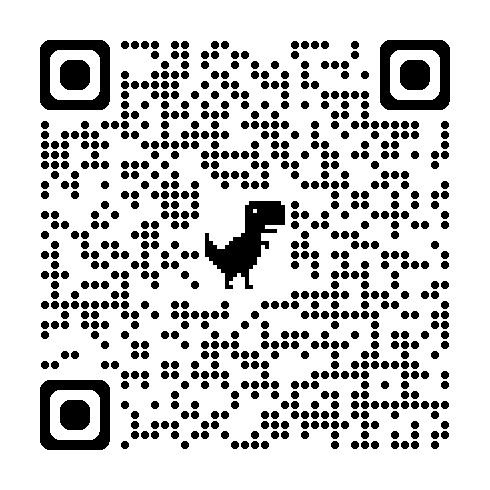

In [ ]:
import sys
project_dir = 'drive/My Drive/24-sabersem'
sys.path.append(project_dir)
from sabersem24utils import *
sc = pd.read_csv(f"{project_dir}/sc.csv")
display(Image(filename=f'{project_dir}/colab.png'))

In [ ]:
project_dir = 'drive/My Drive/24-sabersem'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

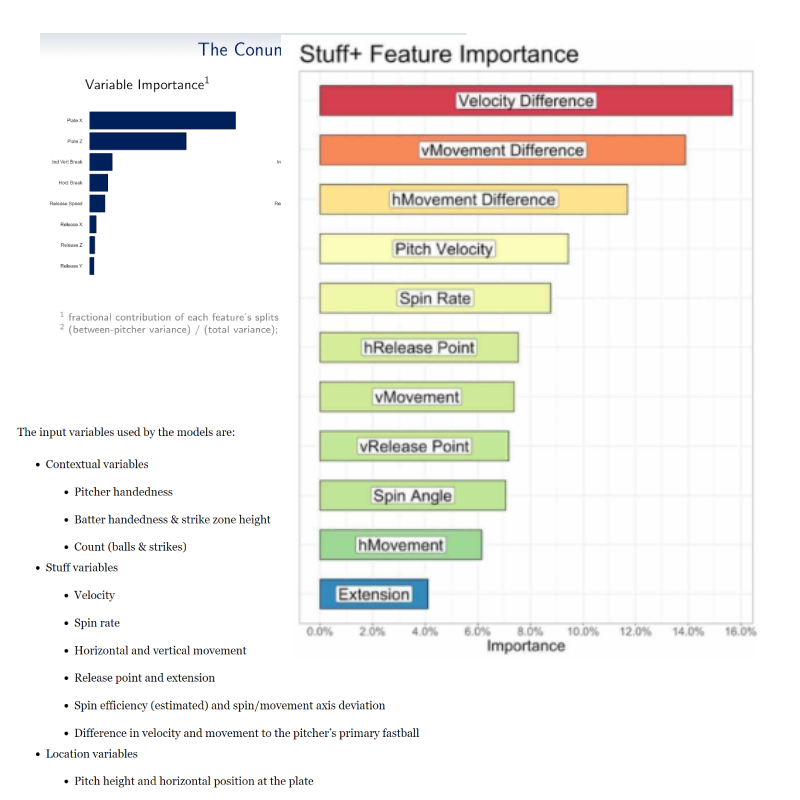


  https://github.com/saberpowers/talks/blob/master/2023/saberseminar/slides.pdf

  https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/

  https://www.nytimes.com/athletic/2641834/2021/06/11/the-pitcher-report-what-exactly-is-stuff-featuring-rich-hill-sam-long-and-more/
  


In [ ]:
stuff_features(project_dir)

In [ ]:
# sc = bb.statcast(start_dt = '2024-03-15', end_dt='2024-12-31')
sc.shape

<IPython.core.display.Javascript object>

(434960, 94)

In [ ]:
sc = clean_data(sc)

<IPython.core.display.Javascript object>


  The data cleaning I do:  
  - Left-handed pitching considerations: flip values for pfx_x, release_pos_x 
  
  - More LHP considerations: spin_axis needs to be flipped, but it's in degrees 
    so be mindful! Multiply by -1, add 360, replace 360 with 0 
  
  - To make differences from "primary pitch" I just use FB
    Filter for FF and SI, group by pitcher, get averages for velo and break
    Merge back onto your original dataframe
    Subtract the averages from each pitch 

  - Code is available on GitHub, there's also several VODs on Twitch

  


In [ ]:
model_data, feats, target, params = get_model_data(sc)

<IPython.core.display.Javascript object>


  Features going into the model:

    'release_speed_diff', 'pfx_x_adj_diff', 'pfx_z_diff',
    'release_speed', 'pfx_x', 'pfx_z','release_spin_rate',
    'spin_axis_adj', 'release_pos_x_adj','release_extension',
    'release_pos_z'

  Model target (DV):
    'delta_run_exp'

  Model parameters:  
    border_count=100 
    depth=8 
    reg_lambda=6 
    eta=0.008 
    n_estimators=300 
    loss_function='MultiRMSE' 

  


<IPython.core.display.Javascript object>

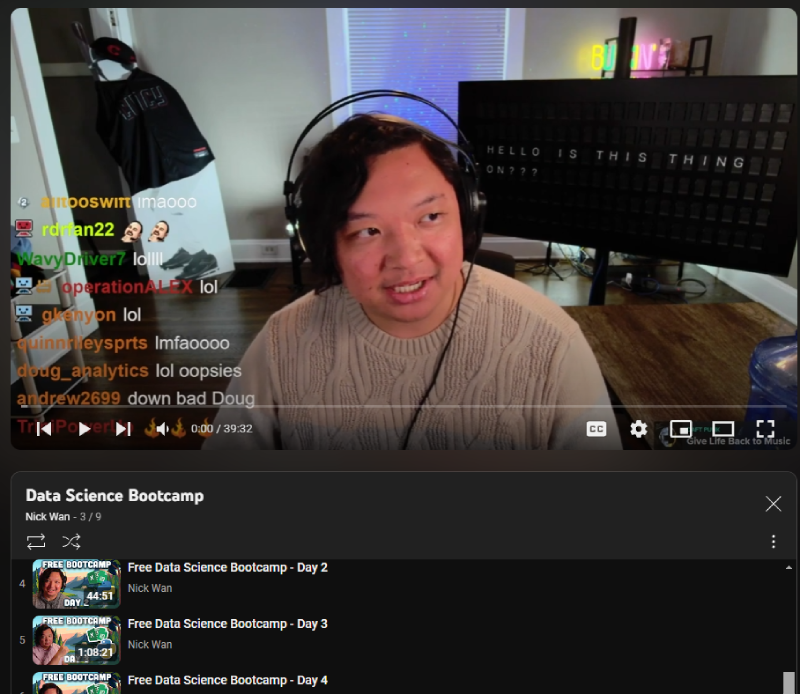


  https://www.youtube.com/watch?v=pocp0KdrIdk&list=PL6PX3YIZuHhwo48MyTASIor4j5NV7qq1W&index=3

  


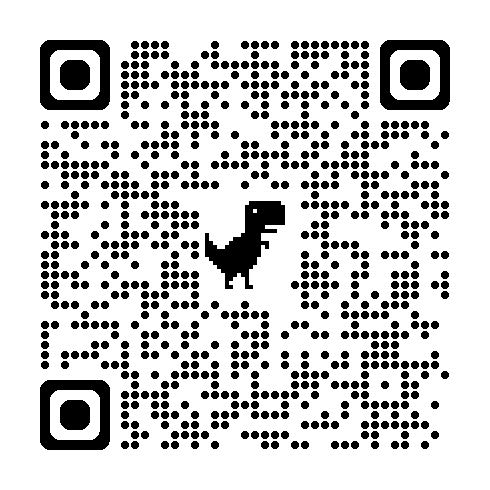

In [ ]:
youtube(project_dir)

In [ ]:
model_data.head()

<IPython.core.display.Javascript object>

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,swing_length,pfx_x_adj,release_pos_x_adj,spin_axis_adj,release_speed_avg,pfx_x_adj_avg,pfx_z_avg,release_speed_diff,pfx_x_adj_diff,pfx_z_diff
0,CU,2024-08-24,84.1,-2.15,6.30,"Johnson, Pierce",682928,572955,field_out,hit_into_play,...,7.15112,0.93,-2.15,45.0,95.448305,-0.834576,1.298644,-11.348305,1.764576,-1.668644
1,CU,2024-08-24,84.9,-2.14,6.25,"Johnson, Pierce",696285,572955,field_out,hit_into_play,...,NaN,0.86,-2.14,44.0,95.448305,-0.834576,1.298644,-10.548305,1.694576,-1.648644
2,CU,2024-08-24,84.4,-2.19,6.32,"Johnson, Pierce",696285,572955,NaN,called_strike,...,NaN,0.73,-2.19,44.0,95.448305,-0.834576,1.298644,-11.048305,1.564576,-1.628644
3,CU,2024-08-24,85.3,-2.25,6.18,"Johnson, Pierce",608336,572955,field_out,hit_into_play,...,5.90609,0.94,-2.25,46.0,95.448305,-0.834576,1.298644,-10.148305,1.774576,-1.538644
15,CU,2024-08-22,84.3,-2.11,6.23,"Johnson, Pierce",670276,572955,walk,ball,...,NaN,0.75,-2.11,43.0,95.448305,-0.834576,1.298644,-11.148305,1.584576,-1.748644


In [ ]:
folds = 5
kf = KFold(folds, shuffle=True)
s = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data), total=False):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(**params)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  s = pd.concat([s, _s])

model_data[f'{target}_cb'] = s
_sc = sc.loc[~sc.index.isin(model_data.index.values), feats].dropna()
model = cb.CatBoostRegressor(**params)
model.fit(model_data.loc[:, feats], model_data[target])
s = pd.Series(model.predict(_sc.loc[:, feats]), index=_sc.index)
sc[f'{target}_cb'] = pd.concat([model_data[f'{target}_cb'],s])


<IPython.core.display.Javascript object>

0it [00:00, ?it/s]

<ipython-input-14-d4a5483b0962>:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s, _s])


In [ ]:
sc.loc[:, ['pitch_name', target, f'{target}_cb']].groupby('pitch_name').mean().sort_values(f'{target}_cb')

<IPython.core.display.Javascript object>

,delta_run_exp,delta_run_exp_cb
pitch_name,,
Slider,-0.001052,-0.004539
Slurve,-0.001530,-0.004508
Sweeper,-0.001153,-0.004484
Knuckle Curve,-0.003833,-0.003832
Cutter,-0.000322,-0.003682
Curveball,0.002348,-0.003672
4-Seam Fastball,-0.000219,-0.003140
Screwball,0.026235,-0.002648
Split-Finger,0.000105,-0.002560


In [ ]:
stuff = 'john'
sc = make_stuff(sc, stuff, target)

<IPython.core.display.Javascript object>


  Once you have an output, you can convert that in a variety of ways

  "Plus" 
  Take the target average of all pitches 
  Divide pitches by avg 

  "Delta" 
  Take the target average of each pitch type for a pitcher 
  Subtract pitches by avg 

  "$$$"
  Use non-rookie salaries to calculate dollars per run 
  Since the target is pitch-level runs, multiply by dollars per run 

  "ERA-ify"
  Take the target average of all pitches 
  Divide your favorite number by the target average 
  Multiply pitches by newly developed constant 

  Unsolicited advice:
  Converting out of your target should have a purpose 
  Conversions can introduce new artifacts 
  Be mindful of your "why" 

  


In [ ]:
lb = make_leaderboard(sc, target, stuff)

<IPython.core.display.Javascript object>

In [ ]:
lb.sort_values(stuff, ascending=False).head(40)

<IPython.core.display.Javascript object>

,pitcher,player_name,pitch_name,delta_run_exp,john
0,663542,"Hudson, Bryan",Sweeper,-0.022745,130.941315
1,502085,"Robertson, David",Cutter,-0.021010,124.935795
2,669461,"Liberatore, Matthew",Curveball,0.022022,124.204334
3,543056,"Coulombe, Danny",Sweeper,-0.033548,124.123057
4,670970,"Morejon, Adrian",Slider,-0.025910,123.549587
5,657006,"Steele, Justin",Slider,-0.008679,123.460746
6,669062,"Miller, Erik",Slider,0.023220,123.281916
7,696136,"Wicks, Jordan",Slider,-0.022500,123.133910
8,666157,"Lodolo, Nick",Curveball,0.017002,122.941888
9,605483,"Snell, Blake",Curveball,-0.027912,122.731938


<IPython.core.display.Javascript object>

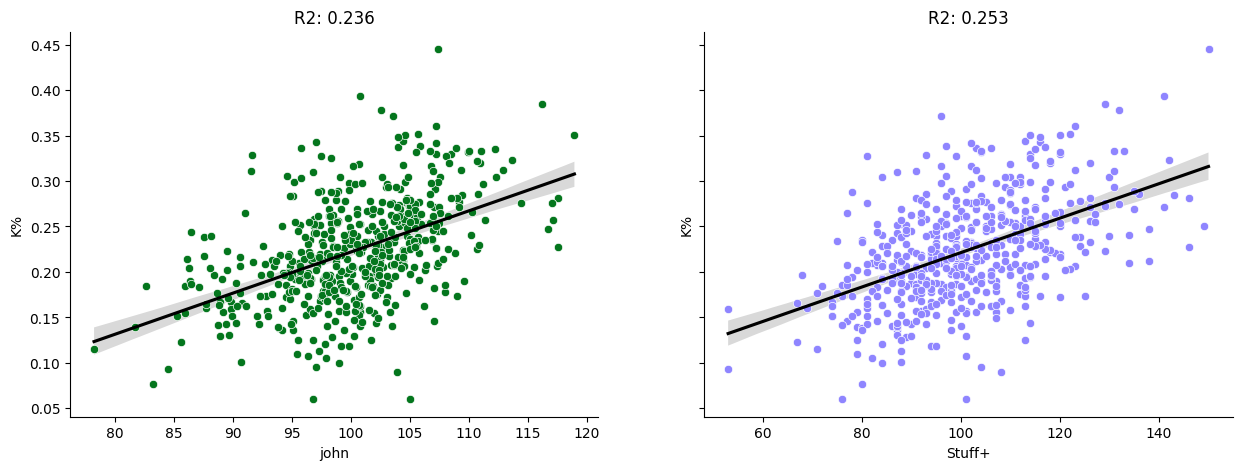

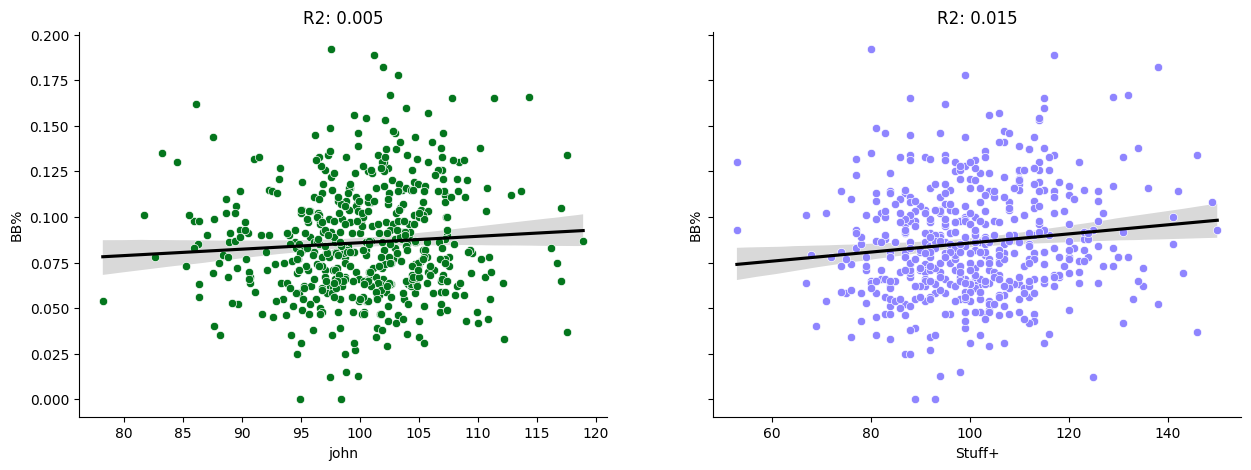

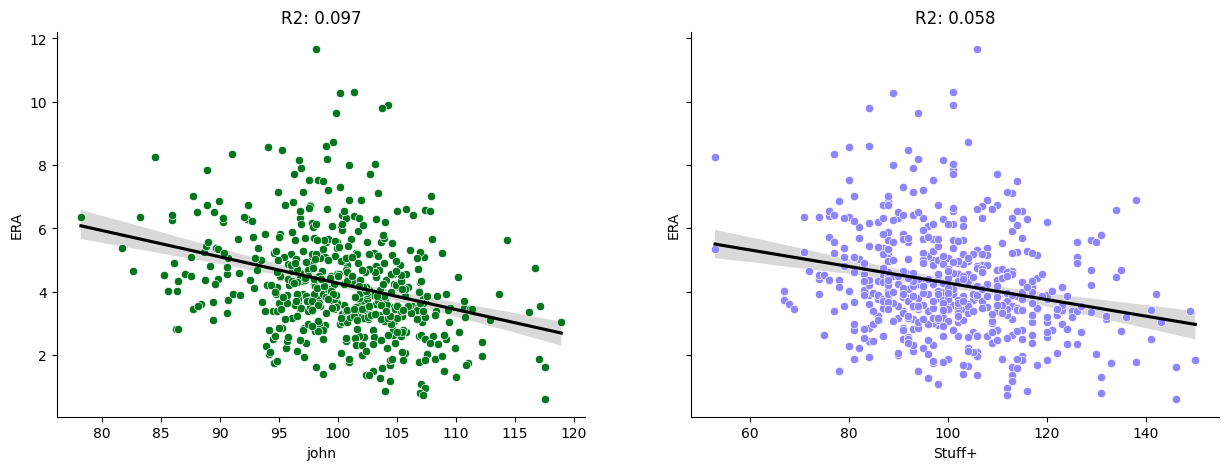

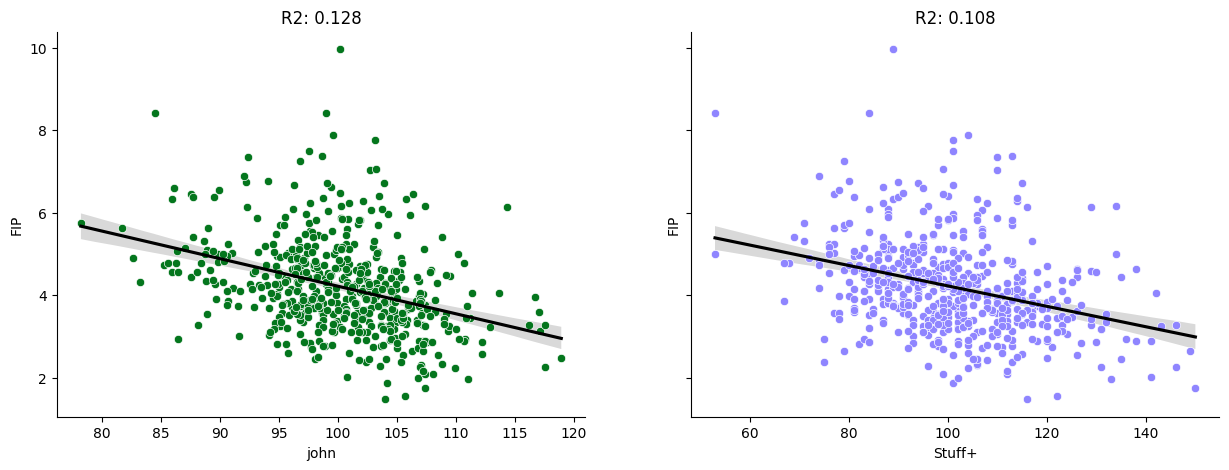

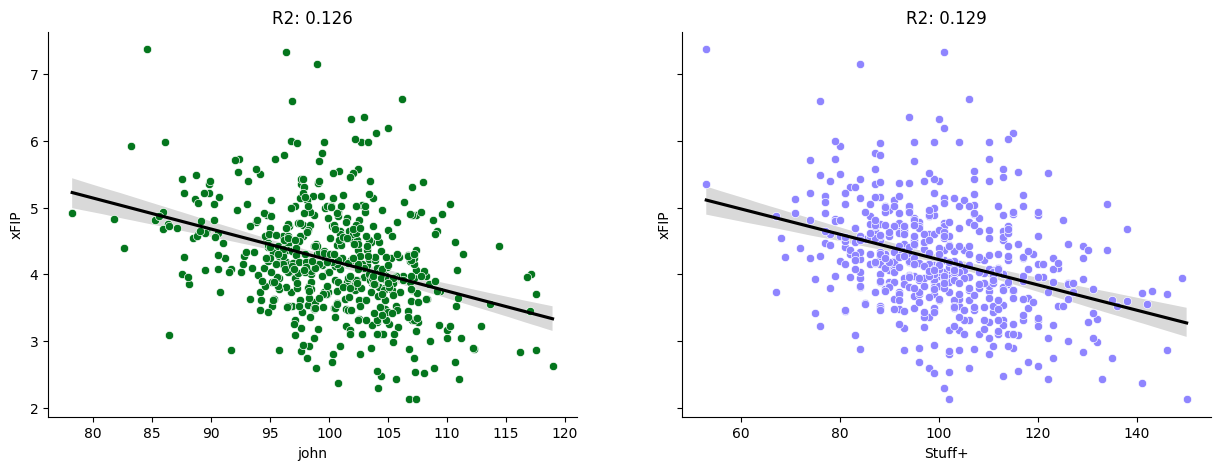

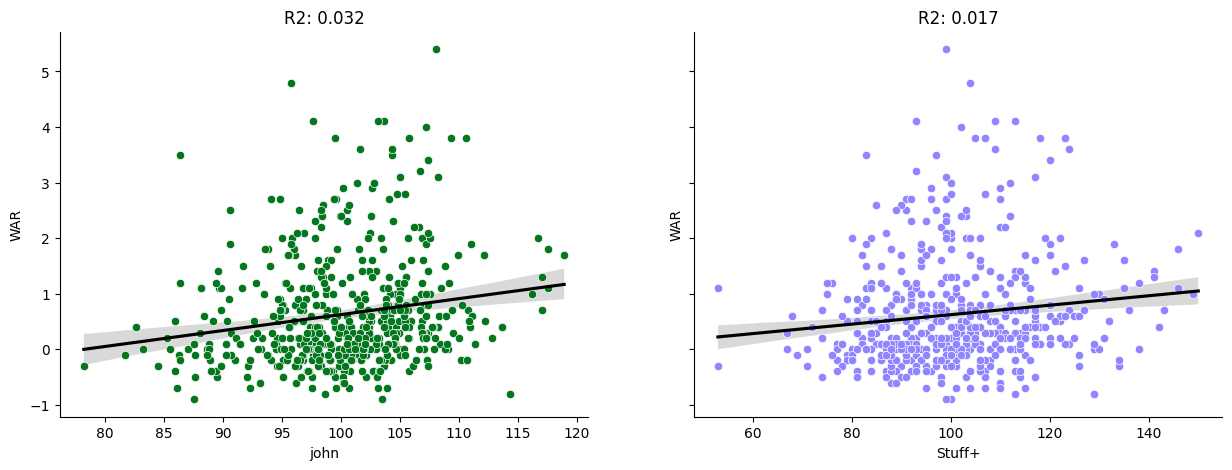

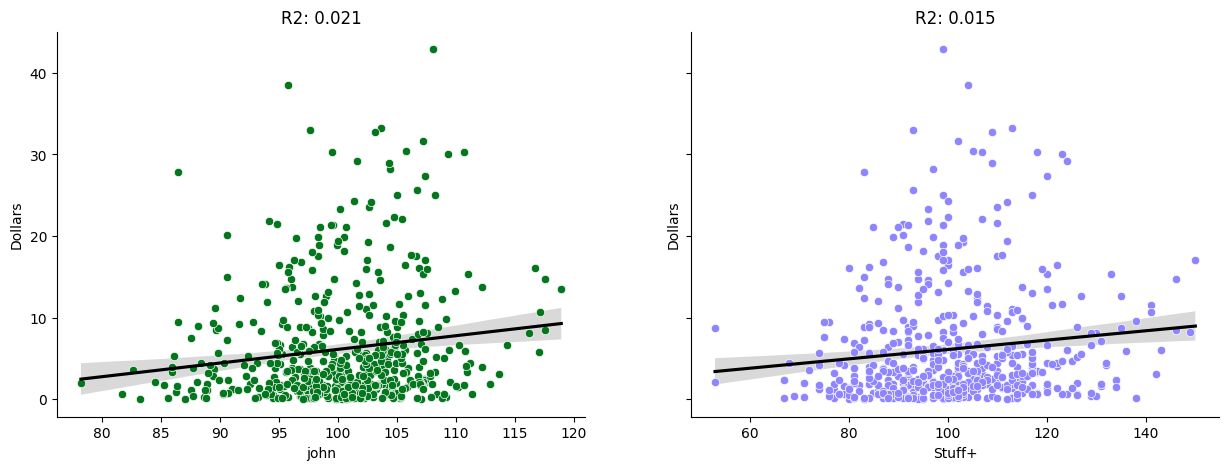

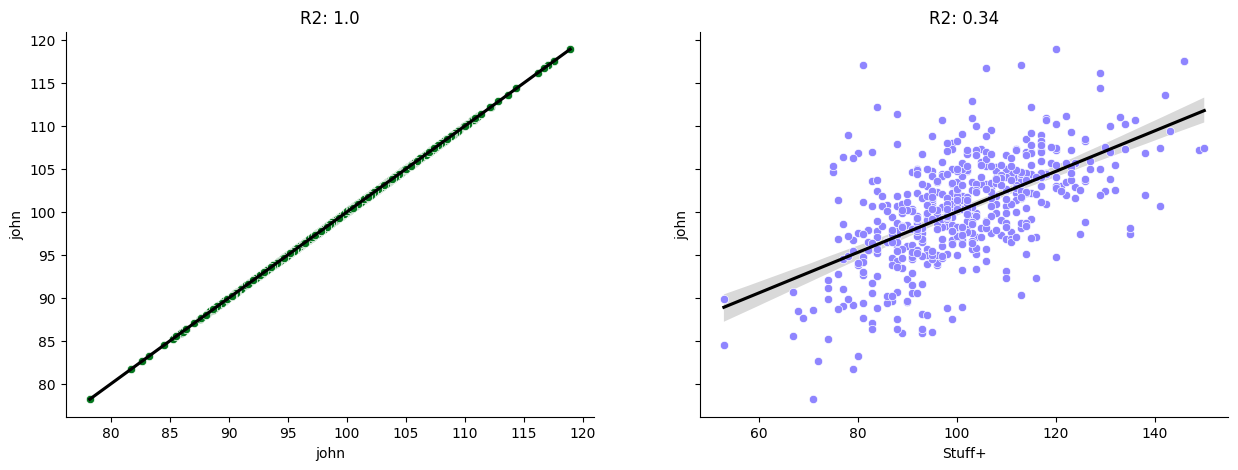

In [ ]:
lb2 = is_it_good(sc, target, stuff, project_dir)

<IPython.core.display.Javascript object>

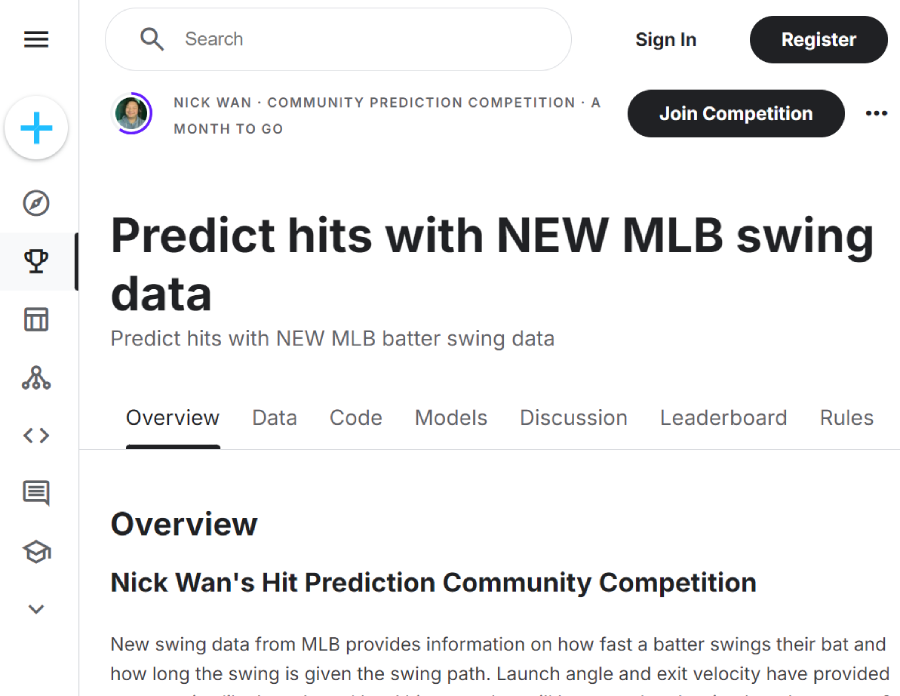

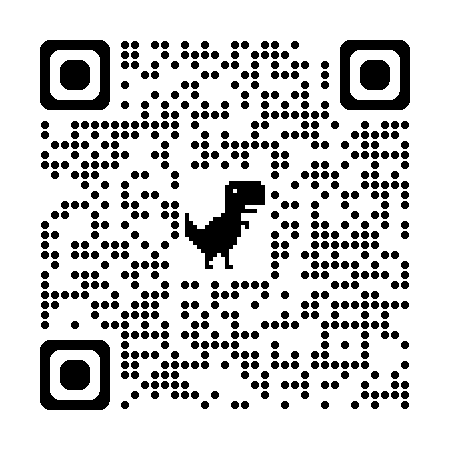


  https://www.kaggle.com/competitions/nwds-batted-balls/overview

  


In [ ]:
kaggle(project_dir)